In [12]:
!pip install tensorflow-gpu==2.8.0 opencv-python tensorflow_datasets matplotlib pycocotools numpy;

In [1]:
!pip install scikit-learn tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s eta 0:00:01


In [1]:
from collections import defaultdict
import random
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from coco_labels_paper import labels as coco_labels

print(tf.__version__)

2.8.0


In [2]:
TRAIN_IMAGES = 'data/coco_onehot_train'
VAL_IMAGES = 'data/coco_onehot_val'

train_files = {}
for d in os.listdir(TRAIN_IMAGES):
    files = os.listdir(f"{TRAIN_IMAGES}/{d}")
    if len(files) > 0:
        train_files[d] = files

val_files = {}
for d in os.listdir(VAL_IMAGES):
    files = os.listdir(f"{VAL_IMAGES}/{d}")
    if len(files) > 0:
        val_files[d] = files

def load_images(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    img = img/255.0
    return img

def preprocess_twins(anchor):
    x = load_images(anchor)
    return x

def get_training_data(epoch_size=1024, training: bool=True):
    X = []

    image_set = train_files if training else val_files
    image_dir = TRAIN_IMAGES if training else VAL_IMAGES

    available_classes = list(image_set.keys())

    for i in range(epoch_size):

        c = random.choice(available_classes)
        anchor = random.choice(image_set[c])

        X.append(f"{image_dir}/{c}/{anchor}")

    return X

def get_training_dataset(epoch_size=1024, training: bool=True):
    data = get_training_data(epoch_size, training)
    x = tf.data.Dataset.from_tensor_slices(data)
    final_data = x
    processed_data = final_data.map(preprocess_twins)
    return processed_data


In [3]:
num_classes = 90
input_shape = (224, 224, 3)

x_train = list(get_training_dataset(epoch_size=1024).take(-1).as_numpy_iterator())
x_test = list(get_training_dataset(epoch_size=1024, training=False).take(-1).as_numpy_iterator())

classes = coco_labels
classes


2022-04-17 17:31:07.053002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 17:31:07.061006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 17:31:07.061203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 17:31:07.062019: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'street sign',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'hat',
 'backpack',
 'umbrella',
 'shoe',
 'eye glasses',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'plate',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'mirror',
 'dining table',
 'window',
 'desk',
 'toilet',
 'door',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'blender',
 'book',
 'clock',
 'vase',
 'scis

In [4]:
target_size = 224  # Resize the input images.
representation_dim = 512  # The dimensions of the features vector.
projection_units = 128  # The projection head of the representation learner.
num_clusters = 20  # Number of clusters.
k_neighbours = 5  # Number of neighbours to consider during cluster learning.
tune_encoder_during_clustering = False  # Freeze the encoder in the cluster learning.


In [5]:
data_preprocessing = keras.Sequential(
    [
        layers.Resizing(target_size, target_size),
        #layers.Normalization(), #Hmmmh....
    ]
)
# Compute the mean and the variance from the data for normalization.
data_preprocessing.layers[-1].adapt(x_train)


AttributeError: 'Resizing' object has no attribute 'adapt'

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(
            height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="nearest"
        ),
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(
            factor=0.15, fill_mode="nearest"
        ),
        layers.RandomZoom(
            height_factor=(-0.3, 0.1), width_factor=(-0.3, 0.1), fill_mode="nearest"
        )
    ]
)


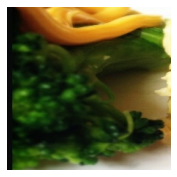

In [6]:

image = x_train[0]
plt.figure(figsize=(3, 3))
plt.imshow((image*255).astype("uint8"))
_ = plt.axis("off")


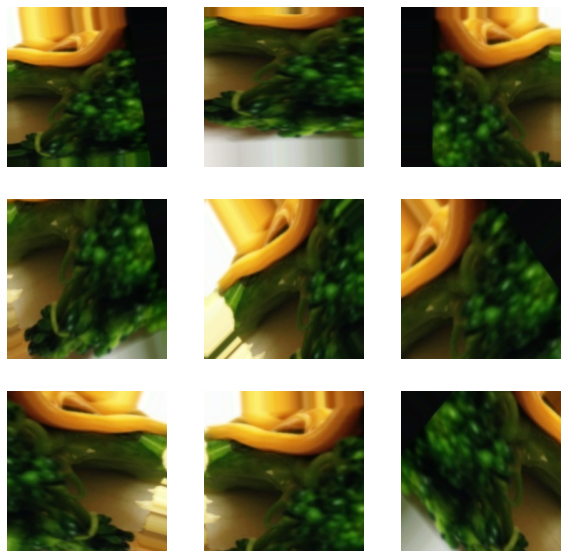

In [7]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_images = data_augmentation(np.array([image])*255)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [8]:
def create_encoder(representation_dim):
    encoder = keras.Sequential(
        [
            keras.applications.ResNet50V2(
                include_top=False, weights=None, pooling="avg"
            ),
            layers.Dense(representation_dim),
        ]
    )
    return encoder


In [9]:
class RepresentationLearner(keras.Model):
    def __init__(
        self,
        encoder,
        projection_units,
        num_augmentations,
        temperature=1.0,
        dropout_rate=0.1,
        l2_normalize=False,
        **kwargs
    ):
        super(RepresentationLearner, self).__init__(**kwargs)
        self.encoder = encoder
        # Create projection head.
        self.projector = keras.Sequential(
            [
                layers.Dropout(dropout_rate),
                layers.Dense(units=projection_units, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
            ]
        )
        self.num_augmentations = num_augmentations
        self.temperature = temperature
        self.l2_normalize = l2_normalize
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_contrastive_loss(self, feature_vectors, batch_size):
        num_augmentations = tf.shape(feature_vectors)[0] // batch_size
        if self.l2_normalize:
            feature_vectors = tf.math.l2_normalize(feature_vectors, -1)
        # The logits shape is [num_augmentations * batch_size, num_augmentations * batch_size].
        logits = (
            tf.linalg.matmul(feature_vectors, feature_vectors, transpose_b=True)
            / self.temperature
        )
        # Apply log-max trick for numerical stability.
        logits_max = tf.math.reduce_max(logits, axis=1)
        logits = logits - logits_max
        # The shape of targets is [num_augmentations * batch_size, num_augmentations * batch_size].
        # targets is a matrix consits of num_augmentations submatrices of shape [batch_size * batch_size].
        # Each [batch_size * batch_size] submatrix is an identity matrix (diagonal entries are ones).
        targets = tf.tile(tf.eye(batch_size), [num_augmentations, num_augmentations])
        # Compute cross entropy loss
        return keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )

    def call(self, inputs):
        # Preprocess the input images.
        #preprocessed = data_preprocessing(inputs)
        # Create augmented versions of the images.
        augmented = []
        for _ in range(self.num_augmentations):
            augmented.append(data_augmentation(inputs))
        augmented = layers.Concatenate(axis=0)(augmented)
        # Generate embedding representations of the images.
        features = self.encoder(augmented)
        # Apply projection head.
        return self.projector(features)

    def train_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        # Run the forward pass and compute the contrastive loss
        with tf.GradientTape() as tape:
            feature_vectors = self(inputs, training=True)
            loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update loss tracker metric
        self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        feature_vectors = self(inputs, training=False)
        loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


In [10]:
# Create vision encoder.
encoder = create_encoder(representation_dim)
# Create representation learner.
representation_learner = RepresentationLearner(
    encoder, projection_units, num_augmentations=2, temperature=0.1
)
# Create a a Cosine decay learning rate scheduler.
lr_scheduler = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, decay_steps=500, alpha=0.1
)
# Compile the model.
representation_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001),
)
# Fit the model.
history = representation_learner.fit(
    x=np.array(x_train),
    batch_size=16,
    epochs=50,  # for better results, increase the number of epochs to 500.
)


Epoch 1/50


2022-04-17 17:31:34.027709: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-04-17 17:31:34.476421: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-17 17:31:35.749512: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


64/64 [==============================] - 20s 212ms/step - loss: 169.7276
Epoch 2/50
64/64 [==============================] - 14s 214ms/step - loss: 41.7501
Epoch 3/50
64/64 [==============================] - 14s 212ms/step - loss: 17.3110
Epoch 4/50
64/64 [==============================] - 14s 212ms/step - loss: 11.0043
Epoch 5/50
64/64 [==============================] - 14s 212ms/step - loss: 9.9505
Epoch 6/50
64/64 [==============================] - 14s 212ms/step - loss: 8.6223
Epoch 7/50
64/64 [==============================] - 14s 212ms/step - loss: 7.4701
Epoch 8/50
64/64 [==============================] - 14s 212ms/step - loss: 7.6766
Epoch 9/50
64/64 [==============================] - 14s 211ms/step - loss: 7.4875
Epoch 10/50
64/64 [==============================] - 14s 213ms/step - loss: 6.2387
Epoch 11/50
64/64 [==============================] - 14s 212ms/step - loss: 6.2149
Epoch 12/50
64/64 [==============================] - 14s 211ms/step - loss: 5.4407
Epoch 13/50
64/64 [

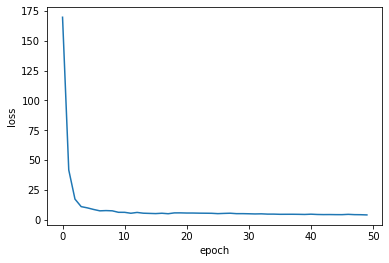

In [11]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()


In [30]:
batch_size = 16
# Get the feature vector representations of the images.
feature_vectors = encoder.predict(np.array(x_train).reshape(-1,224,224,3), batch_size=batch_size, verbose=1)
# Normalize the feature vectores.
feature_vectors = tf.math.l2_normalize(feature_vectors, -1)


2022-04-17 17:48:57.199952: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-17 17:48:57.199988: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-17 17:48:57.429878: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 408.06MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-17 17:48:57.542929: W tensorflow/core/common_runtime/bfc_allocator.cc:275] All

2/2 [==============================] - 6s 112ms/step


In [31]:
feature_vectors.shape

TensorShape([1024, 512])

In [32]:
neighbours = []
num_batches = feature_vectors.shape[0] // batch_size
for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = feature_vectors[start_idx:end_idx]
    # Compute the dot similarity.
    similarities = tf.linalg.matmul(current_batch, feature_vectors, transpose_b=True)
    # Get the indices of most similar vectors.
    _, indices = tf.math.top_k(similarities, k=k_neighbours + 1, sorted=True)
    # Add the indices to the neighbours.
    neighbours.append(indices[..., 1:])

neighbours = np.reshape(np.array(neighbours), (-1, k_neighbours))


100%|██████████| 2/2 [00:00<00:00, 1201.46it/s]


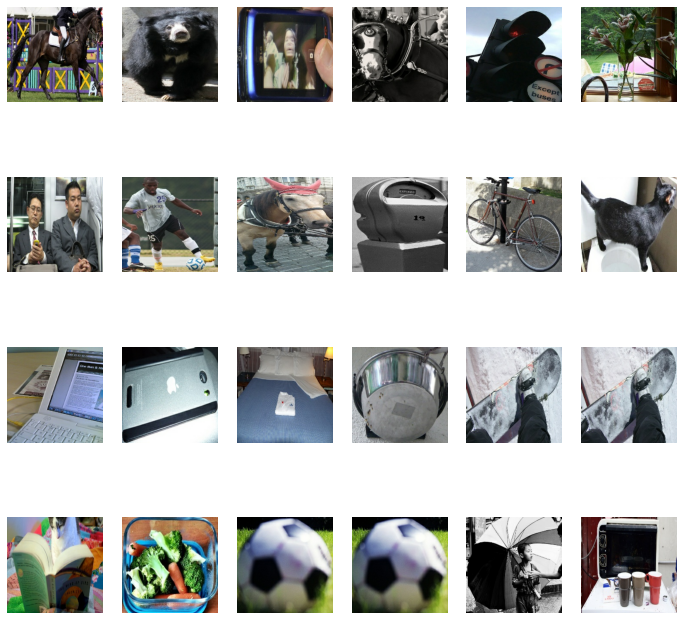

In [33]:
nrows = 4
ncols = k_neighbours + 1

plt.figure(figsize=(12, 12))
position = 1
for _ in range(nrows):
    anchor_idx = np.random.choice(range(x_train.shape[0]))
    neighbour_indicies = neighbours[anchor_idx]
    indices = [anchor_idx] + neighbour_indicies.tolist()
    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        plt.imshow((x_train[indices[j]]*255.0).astype("uint8"))
        #plt.title(classes[y_data[indices[j]][0]])
        plt.axis("off")
        position += 1


In [34]:
class ClustersConsistencyLoss(keras.losses.Loss):
    def __init__(self):
        super(ClustersConsistencyLoss, self).__init__()

    def __call__(self, target, similarity, sample_weight=None):
        # Set targets to be ones.
        target = tf.ones_like(similarity)
        # Compute cross entropy loss.
        loss = keras.losses.binary_crossentropy(
            y_true=target, y_pred=similarity, from_logits=True
        )
        return tf.math.reduce_mean(loss)


In [35]:
class ClustersEntropyLoss(keras.losses.Loss):
    def __init__(self, entropy_loss_weight=1.0):
        super(ClustersEntropyLoss, self).__init__()
        self.entropy_loss_weight = entropy_loss_weight

    def __call__(self, target, cluster_probabilities, sample_weight=None):
        # Ideal entropy = log(num_clusters).
        num_clusters = tf.cast(tf.shape(cluster_probabilities)[-1], tf.dtypes.float32)
        target = tf.math.log(num_clusters)
        # Compute the overall clusters distribution.
        cluster_probabilities = tf.math.reduce_mean(cluster_probabilities, axis=0)
        # Replacing zero probabilities - if any - with a very small value.
        cluster_probabilities = tf.clip_by_value(
            cluster_probabilities, clip_value_min=1e-8, clip_value_max=1.0
        )
        # Compute the entropy over the clusters.
        entropy = -tf.math.reduce_sum(
            cluster_probabilities * tf.math.log(cluster_probabilities)
        )
        # Compute the difference between the target and the actual.
        loss = target - entropy
        return loss


In [36]:
def create_clustering_model(encoder, num_clusters, name=None):
    inputs = keras.Input(shape=input_shape)
    # Preprocess the input images.
    #preprocessed = data_preprocessing(inputs)
    # Apply data augmentation to the images.
    augmented = data_augmentation(inputs)
    # Generate embedding representations of the images.
    features = encoder(augmented)
    # Assign the images to clusters.
    outputs = layers.Dense(units=num_clusters, activation="softmax")(features)
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model


In [37]:
def create_clustering_learner(clustering_model):
    anchor = keras.Input(shape=input_shape, name="anchors")
    neighbours = keras.Input(
        shape=tuple([k_neighbours]) + input_shape, name="neighbours"
    )
    # Changes neighbours shape to [batch_size * k_neighbours, width, height, channels]
    neighbours_reshaped = tf.reshape(neighbours, shape=tuple([-1]) + input_shape)
    # anchor_clustering shape: [batch_size, num_clusters]
    anchor_clustering = clustering_model(anchor)
    # neighbours_clustering shape: [batch_size * k_neighbours, num_clusters]
    neighbours_clustering = clustering_model(neighbours_reshaped)
    # Convert neighbours_clustering shape to [batch_size, k_neighbours, num_clusters]
    neighbours_clustering = tf.reshape(
        neighbours_clustering,
        shape=(-1, k_neighbours, tf.shape(neighbours_clustering)[-1]),
    )
    # similarity shape: [batch_size, 1, k_neighbours]
    similarity = tf.linalg.einsum(
        "bij,bkj->bik", tf.expand_dims(anchor_clustering, axis=1), neighbours_clustering
    )
    # similarity shape:  [batch_size, k_neighbours]
    similarity = layers.Lambda(lambda x: tf.squeeze(x, axis=1), name="similarity")(
        similarity
    )
    # Create the model.
    model = keras.Model(
        inputs=[anchor, neighbours],
        outputs=[similarity, anchor_clustering],
        name="clustering_learner",
    )
    return model


In [40]:
# If tune_encoder_during_clustering is set to False,
# then freeze the encoder weights.
for layer in encoder.layers:
    layer.trainable = tune_encoder_during_clustering
# Create the clustering model and learner.
clustering_model = create_clustering_model(encoder, num_clusters, name="clustering")
clustering_learner = create_clustering_learner(clustering_model)
# Instantiate the model losses.
losses = [ClustersConsistencyLoss(), ClustersEntropyLoss(entropy_loss_weight=5)]
# Create the model inputs and labels.
inputs = {"anchors": x_train, "neighbours": tf.gather(x_train, neighbours)}
labels = tf.ones(shape=(x_train.shape[0]))
# Compile the model.
clustering_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.0001),
    loss=losses,
)

# Begin training the model.
clustering_learner.fit(x=inputs, y=labels, batch_size=16, epochs=50)


Epoch 1/50
64/64 [==============================] - 17s 189ms/step - loss: 0.6782 - similarity_loss: 0.6565 - clustering_loss: 0.0217
Epoch 2/50
64/64 [==============================] - 12s 188ms/step - loss: 0.6785 - similarity_loss: 0.6576 - clustering_loss: 0.0209
Epoch 3/50
64/64 [==============================] - 12s 189ms/step - loss: 0.6753 - similarity_loss: 0.6577 - clustering_loss: 0.0176
Epoch 4/50
64/64 [==============================] - 12s 189ms/step - loss: 0.6878 - similarity_loss: 0.6557 - clustering_loss: 0.0321
Epoch 5/50
64/64 [==============================] - 12s 189ms/step - loss: 0.6725 - similarity_loss: 0.6571 - clustering_loss: 0.0154
Epoch 6/50
64/64 [==============================] - 12s 189ms/step - loss: 0.6841 - similarity_loss: 0.6549 - clustering_loss: 0.0292
Epoch 7/50
64/64 [==============================] - 12s 190ms/step - loss: 0.6948 - similarity_loss: 0.6557 - clustering_loss: 0.0391
Epoch 8/50
64/64 [==============================] - 12s 189ms/

KeyboardInterrupt: 

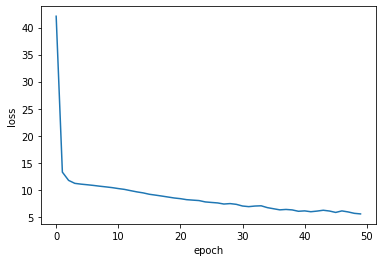

In [22]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()


In [42]:
# Get the cluster probability distribution of the input images.
clustering_probs = clustering_model.predict(x_train, batch_size=batch_size, verbose=1)
# Get the cluster of the highest probability.
cluster_assignments = tf.math.argmax(clustering_probs, axis=-1).numpy()
# Store the clustering confidence.
# Images with the highest clustering confidence are considered the 'prototypes'
# of the clusters.
cluster_confidence = tf.math.reduce_max(clustering_probs, axis=-1).numpy()


64/64 [==============================] - 2s 34ms/step


In [43]:
clusters = defaultdict(list)
for idx, c in enumerate(cluster_assignments):
    clusters[c].append((idx, cluster_confidence[idx]))

for c in range(num_clusters):
    print("cluster", c, ":", len(clusters[c]))


cluster 0 : 0
cluster 1 : 32
cluster 2 : 164
cluster 3 : 43
cluster 4 : 0
cluster 5 : 44
cluster 6 : 0
cluster 7 : 0
cluster 8 : 129
cluster 9 : 21
cluster 10 : 50
cluster 11 : 72
cluster 12 : 114
cluster 13 : 2
cluster 14 : 4
cluster 15 : 323
cluster 16 : 10
cluster 17 : 14
cluster 18 : 1
cluster 19 : 1


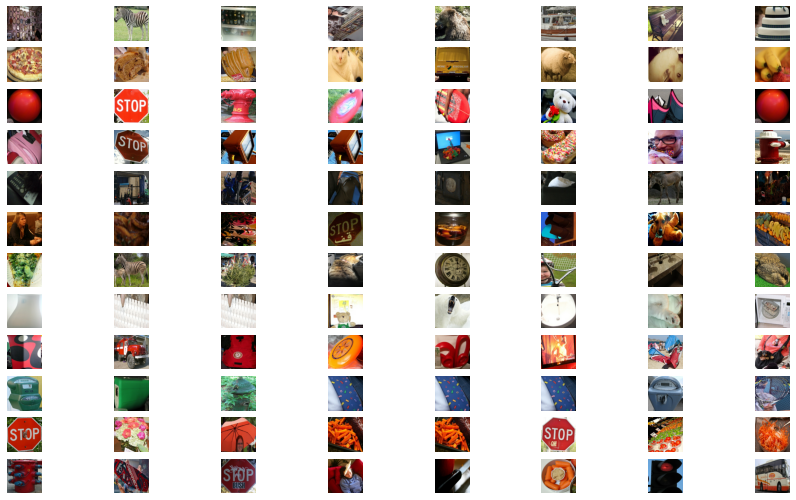

In [49]:
num_images = 8
plt.figure(figsize=(15, 15))
position = 1
for c in range(num_clusters):
    cluster_instances = sorted(clusters[c], key=lambda kv: kv[1], reverse=True)

    for j in range(num_images):
        if len(cluster_instances) <= num_images:
            continue
        image_idx = cluster_instances[j][0]
        plt.subplot(num_clusters, num_images, position)
        plt.imshow((x_train[image_idx]*255.0).astype("uint8"))
        #plt.title(classes[y_data[image_idx][0]])
        plt.axis("off")
        position += 1


In [26]:
cluster_label_counts = dict()

for c in range(num_clusters):
    cluster_label_counts[c] = [0] * num_classes
    instances = clusters[c]
    for i, _ in instances:
        cluster_label_counts[c][y_data[i][0]] += 1

    cluster_label_idx = np.argmax(cluster_label_counts[c])
    correct_count = np.max(cluster_label_counts[c])
    cluster_size = len(clusters[c])
    accuracy = (
        np.round((correct_count / cluster_size) * 100, 2) if cluster_size > 0 else 0
    )
    cluster_label = classes[cluster_label_idx]
    print("cluster", c, "label is:", cluster_label, " -  accuracy:", accuracy, "%")


cluster 0 label is: frog  -  accuracy: 33.29 %
cluster 1 label is: truck  -  accuracy: 25.48 %
cluster 2 label is: ship  -  accuracy: 40.28 %
cluster 3 label is: bird  -  accuracy: 19.77 %
cluster 4 label is: airplane  -  accuracy: 33.37 %
cluster 5 label is: automobile  -  accuracy: 23.17 %
cluster 6 label is: automobile  -  accuracy: 20.25 %
cluster 7 label is: frog  -  accuracy: 20.32 %
cluster 8 label is: deer  -  accuracy: 30.33 %
cluster 9 label is: deer  -  accuracy: 27.91 %
cluster 10 label is: dog  -  accuracy: 21.96 %
cluster 11 label is: airplane  -  accuracy: 23.81 %
cluster 12 label is: truck  -  accuracy: 29.04 %
cluster 13 label is: deer  -  accuracy: 19.56 %
cluster 14 label is: deer  -  accuracy: 18.17 %
cluster 15 label is: airplane  -  accuracy: 37.18 %
cluster 16 label is: horse  -  accuracy: 24.52 %
cluster 17 label is: frog  -  accuracy: 21.82 %
cluster 18 label is: dog  -  accuracy: 17.16 %
cluster 19 label is: horse  -  accuracy: 13.9 %
